# Modeling 1

In [108]:
# imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import json
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import TensorDataset, DataLoader, Dataset
from torchvision import transforms
import torchvision.models as models
from torchvision.models import resnet18, ResNet18_Weights

In [82]:
# check if gpu is available, set device

device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
device

device(type='mps')

In [83]:
# import data

with open('data/df_kohaku_sanke_showa.json', 'r') as f:
  data = json.load(f)

df = pd.DataFrame(data)

df.head()

,image_path,label
0,champkoi_data/18f755_A_32_Female_Kohaku_[Nogam...,kohaku
1,gckoi_data/d9a7dbc_HIGH_QUALITY_SAKAI_BLOODLIN...,kohaku
2,gckoi_data/88ec869_ISA_KOHAKU_GUARANTEE_FEMALE...,kohaku
3,gckoi_data/3a7df4e_DAINICHI_3SAI_FEMALE_KOHAKU...,kohaku
4,gckoi_data/cb26670_DAINICHI_BLOODLINE_KOHAKU_2...,kohaku


# Prepare the Data for Modeling

In [84]:
# use the labelencoder to encode the classes

le = LabelEncoder()
df['label_encoded'] = le.fit_transform(df['label'])
df['label_encoded'].value_counts()

label_encoded
0    264
1    237
2    185
Name: count, dtype: int64

In [85]:
# get the mapping

label_map = {}
for i in range(len(le.classes_)):
  label_map[i] = le.inverse_transform([i])[0]

label_map

{0: 'kohaku', 1: 'sanke', 2: 'showa'}

In [86]:
# double check the data

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 686 entries, 0 to 685
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   image_path     686 non-null    object
 1   label          686 non-null    object
 2   label_encoded  686 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 16.2+ KB


In [87]:
# train-test-val-split

train_df, testval_df = train_test_split(df[['image_path', 'label_encoded']], test_size=0.3, shuffle=True, random_state=42, stratify=df['label_encoded'])
val_df, test_df = train_test_split(testval_df, test_size=0.5, shuffle=True, random_state=42, stratify=testval_df['label_encoded'])

# check the shape

train_df.shape, val_df.shape, test_df.shape

((480, 2), (103, 2), (103, 2))

In [88]:
# create a custom class for the image dataset

class CustomImageDataset(Dataset):
  def __init__(self, dataframe, img_dir, transform=None):
    self.df = dataframe.reset_index(drop=True)
    self.img_dir = img_dir
    self.transform = transform

  # calculate how many samples are in the dataset
  def __len__(self):
    return len(self.df)

  # how to fetch one image and label when given an index number
  def __getitem__(self, idx):
    img_path = os.path.join(self.img_dir, self.df.loc[idx, 'image_path'])
    image = Image.open(img_path).convert('RGB')
    label = self.df.loc[idx, 'label_encoded']
    if self.transform:
      image = self.transform(image)
    return image, torch.tensor(label, dtype=torch.long)

In [89]:
# define transformers and loaders

transform = transforms.Compose([
  transforms.Resize((224, 224)),
  transforms.ToTensor()
])

dir_path = '../pictures/'

train_ds = CustomImageDataset(train_df, img_dir=dir_path, transform=transform)
val_ds = CustomImageDataset(val_df, img_dir=dir_path, transform=transform)
test_ds = CustomImageDataset(test_df, img_dir=dir_path, transform=transform)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False)

In [90]:
# check the tensors

for images, labels in train_loader:
    print(type(images), images.shape)
    print(type(labels), labels.shape)
    break

<class 'torch.Tensor'> torch.Size([32, 3, 224, 224])
<class 'torch.Tensor'> torch.Size([32])


# Define the Model

In [91]:
# define the model

num_classes = len(label_map)

model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

/Users/annahan/miniforge3/envs/pytorch-1/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/annahan/miniforge3/envs/pytorch-1/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [92]:
# define loss and optimizer

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [93]:
# create the training loop

num_epochs = 20

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
  # set the model to training mode
  model.train()
  # initialize loss tracking
  total_train_loss = 0
  train_correct = 0
  train_total = 0

  # loop through training data in batches
  for images, labels in train_loader:
    images = images.to(device) # move data to MPS
    labels = labels.to(device) # move data to MPS

    # reset the gradients
    optimizer.zero_grad()
    # forward pass
    outputs = model(images)
    # compute the loss
    loss = criterion(outputs, labels)
    # backward pass
    loss.backward()
    # update model weights
    optimizer.step()

    # add batch loss to total
    total_train_loss += loss.item()

    _, predicted = torch.max(outputs, 1)
    train_correct += (predicted == labels).sum().item()
    train_total += labels.size(0)

  avg_train_loss = total_train_loss / len(train_loader)
  train_acc = train_correct / train_total

  train_losses.append(avg_train_loss)
  train_accuracies.append(train_acc)

  # VALIDATION
  model.eval()
  total_val_loss = 0
  val_correct = 0
  val_total = 0

  with torch.no_grad():
    for images, labels in val_loader:
      images = images.to(device)
      labels = labels.to(device)

      outputs = model(images)
      loss = criterion(outputs, labels)
      total_val_loss += loss.item()

      _, predicted = torch.max(outputs, 1)
      val_correct += (predicted == labels).sum().item()
      val_total += labels.size(0)

  avg_val_loss = total_val_loss / len(val_loader)
  val_acc = val_correct / val_total

  val_losses.append(avg_val_loss)
  val_accuracies.append(val_acc)

  # print loss for this epochs
  print(f"Epoch {epoch+1}/{num_epochs} | "
        f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.2%} | "
        f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.2%}")

Epoch 1/20 | Train Loss: 0.5849, Train Acc: 77.08% | Val Loss: 5.8809, Val Acc: 52.43%
Epoch 2/20 | Train Loss: 0.2365, Train Acc: 90.62% | Val Loss: 0.3501, Val Acc: 88.35%
Epoch 3/20 | Train Loss: 0.1072, Train Acc: 97.08% | Val Loss: 2.3107, Val Acc: 72.82%
Epoch 4/20 | Train Loss: 0.1260, Train Acc: 94.58% | Val Loss: 0.6224, Val Acc: 81.55%
Epoch 5/20 | Train Loss: 0.1038, Train Acc: 96.25% | Val Loss: 1.0925, Val Acc: 82.52%
Epoch 6/20 | Train Loss: 0.0875, Train Acc: 97.50% | Val Loss: 0.1859, Val Acc: 93.20%
Epoch 7/20 | Train Loss: 0.0506, Train Acc: 98.33% | Val Loss: 0.1782, Val Acc: 94.17%
Epoch 8/20 | Train Loss: 0.0205, Train Acc: 99.17% | Val Loss: 0.7550, Val Acc: 85.44%
Epoch 9/20 | Train Loss: 0.0258, Train Acc: 98.75% | Val Loss: 0.5044, Val Acc: 87.38%
Epoch 10/20 | Train Loss: 0.0334, Train Acc: 99.17% | Val Loss: 0.5660, Val Acc: 84.47%
Epoch 11/20 | Train Loss: 0.0177, Train Acc: 99.17% | Val Loss: 1.2193, Val Acc: 79.61%
Epoch 12/20 | Train Loss: 0.0373, Train A

In [94]:
# calculate the validation accuracy

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
  for images, labels in val_loader:
    images = images.to(device)
    labels = labels.to(device)

    outputs = model(images)
    _, predicted  = torch.max(outputs, 1)

    all_preds.extend(predicted.cpu().numpy())
    all_labels.extend(labels.cpu().numpy())

acc = accuracy_score(all_labels, all_preds)
print(f"Validation Accuracy: {acc:.2%}")

Validation Accuracy: 96.12%


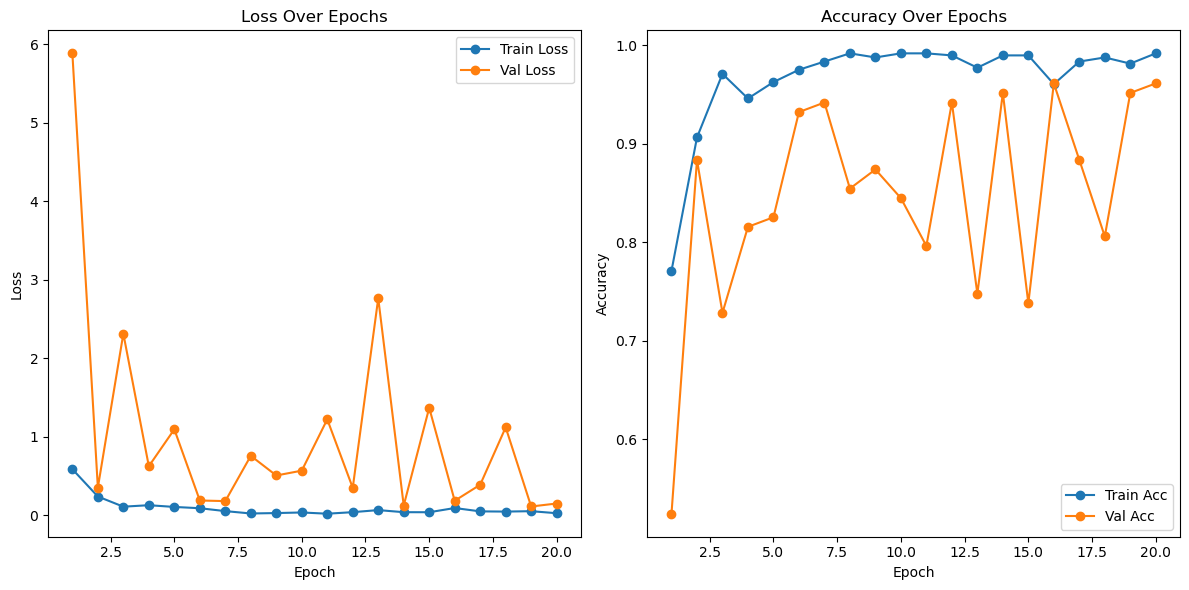

In [98]:
# plot the loss and accuracy over epochs

epochs = range(1, num_epochs +1)
plt.figure(figsize=(12,6))

# plot the loss
plt.subplot(1,2,1)
plt.plot(epochs, train_losses, label='Train Loss', marker='o')
plt.plot(epochs, val_losses, label='Val Loss', marker ='o')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# plot the accuracy
plt.subplot(1,2,2)
plt.plot(epochs, train_accuracies, label='Train Acc', marker='o')
plt.plot(epochs, val_accuracies, label='Val Acc', marker='o')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

              precision    recall  f1-score   support

      kohaku       1.00      1.00      1.00        39
       sanke       0.90      1.00      0.95        36
       showa       1.00      0.86      0.92        28

    accuracy                           0.96       103
   macro avg       0.97      0.95      0.96       103
weighted avg       0.97      0.96      0.96       103



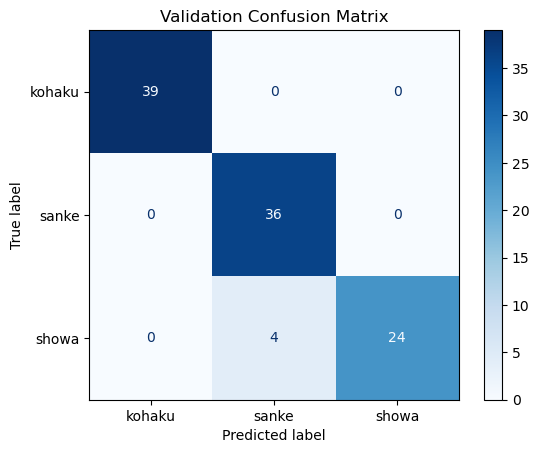

In [99]:
# check the classification report

print(classification_report(all_labels, all_preds, target_names=le.classes_))

# create the confusion matrix

cm = confusion_matrix(all_labels, all_preds)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap='Blues', values_format='d')
plt.title("Validation Confusion Matrix")
plt.show()

- The val accuracy fluctuates dramatically up and down. This may be a sign that the learning rate is too high. I will use ReduceLROnPlateau to see if it helps to stablize the performance.

# Add Reduce Learning Rate on Plateau and Early Stopping

In [110]:
# define the model

num_classes = len(label_map)

model = resnet18(weights=ResNet18_Weights.DEFAULT)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

# define loss and optimizer

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# define a scheduler to reduce learning rate on plateau

scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

In [111]:
# create the training loop

num_epochs = 10

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# add early stopping

best_val_loss = float('inf')
patience = 5
epochs_no_improve = 0


for epoch in range(num_epochs):
  # set the model to training mode
  model.train()
  # initialize loss tracking
  total_train_loss = 0
  train_correct = 0
  train_total = 0

  # loop through training data in batches
  for images, labels in train_loader:
    images = images.to(device) # move data to MPS
    labels = labels.to(device) # move data to MPS

    # reset the gradients
    optimizer.zero_grad()
    # forward pass
    outputs = model(images)
    # compute the loss
    loss = criterion(outputs, labels)
    # backward pass
    loss.backward()
    # update model weights
    optimizer.step()

    # add batch loss to total
    total_train_loss += loss.item()

    _, predicted = torch.max(outputs, 1)
    train_correct += (predicted == labels).sum().item()
    train_total += labels.size(0)

  avg_train_loss = total_train_loss / len(train_loader)
  train_acc = train_correct / train_total

  train_losses.append(avg_train_loss)
  train_accuracies.append(train_acc)

  # VALIDATION
  model.eval()
  total_val_loss = 0
  val_correct = 0
  val_total = 0

  with torch.no_grad():
    for images, labels in val_loader:
      images = images.to(device)
      labels = labels.to(device)

      outputs = model(images)
      loss = criterion(outputs, labels)
      total_val_loss += loss.item()

      _, predicted = torch.max(outputs, 1)
      val_correct += (predicted == labels).sum().item()
      val_total += labels.size(0)

  avg_val_loss = total_val_loss / len(val_loader)
  val_acc = val_correct / val_total

  val_losses.append(avg_val_loss)
  val_accuracies.append(val_acc)

  # print loss for this epochs
  print(f"Epoch {epoch+1}/{num_epochs} | "
        f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.2%} | "
        f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.2%} | "
        f"Current LR:", optimizer.param_groups[0]['lr'])

  scheduler.step(avg_val_loss)

  if avg_val_loss < best_val_loss:
    best_val_loss = avg_val_loss
    epochs_no_improve = 0
    torch.save(model.state_dict(), 'best_model.pt')
  else:
    epochs_no_improve += 1

  if epochs_no_improve >= patience:
    print(f"Early stopping at epoch {epoch+1}")
    break

Epoch 1/10 | Train Loss: 0.6271, Train Acc: 76.67% | Val Loss: 1.4730, Val Acc: 76.70% | Current LR: 0.001
Epoch 2/10 | Train Loss: 0.2107, Train Acc: 92.50% | Val Loss: 2.7582, Val Acc: 70.87% | Current LR: 0.001
Epoch 3/10 | Train Loss: 0.2360, Train Acc: 91.25% | Val Loss: 0.5727, Val Acc: 82.52% | Current LR: 0.001
Epoch 4/10 | Train Loss: 0.1424, Train Acc: 95.62% | Val Loss: 0.2268, Val Acc: 90.29% | Current LR: 0.001
Epoch 5/10 | Train Loss: 0.0653, Train Acc: 97.92% | Val Loss: 0.7580, Val Acc: 81.55% | Current LR: 0.001
Epoch 6/10 | Train Loss: 0.0403, Train Acc: 98.33% | Val Loss: 1.2014, Val Acc: 71.84% | Current LR: 0.001
Epoch 7/10 | Train Loss: 0.0463, Train Acc: 98.33% | Val Loss: 0.3543, Val Acc: 89.32% | Current LR: 0.001
Epoch 8/10 | Train Loss: 0.0240, Train Acc: 99.17% | Val Loss: 0.1594, Val Acc: 95.15% | Current LR: 0.0005
Epoch 9/10 | Train Loss: 0.0211, Train Acc: 99.38% | Val Loss: 0.1626, Val Acc: 97.09% | Current LR: 0.0005
Epoch 10/10 | Train Loss: 0.0090, T

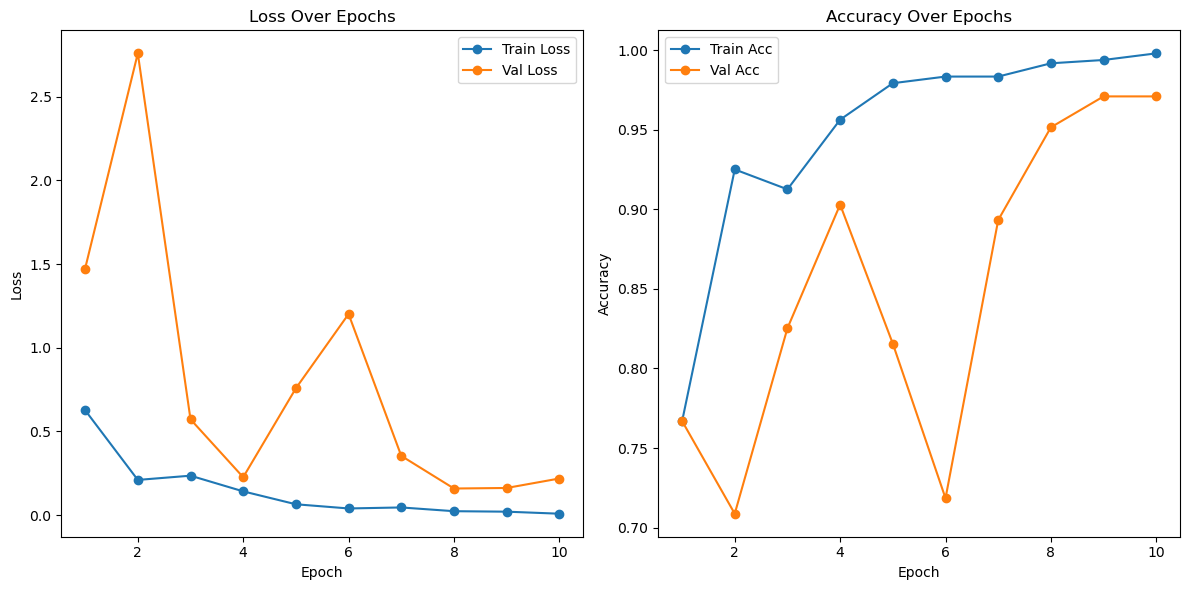

In [112]:
# plot the loss and accuracy over epochs

epochs = range(1, num_epochs +1)
plt.figure(figsize=(12,6))

# plot the loss
plt.subplot(1,2,1)
plt.plot(epochs, train_losses, label='Train Loss', marker='o')
plt.plot(epochs, val_losses, label='Val Loss', marker ='o')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# plot the accuracy
plt.subplot(1,2,2)
plt.plot(epochs, train_accuracies, label='Train Acc', marker='o')
plt.plot(epochs, val_accuracies, label='Val Acc', marker='o')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

              precision    recall  f1-score   support

      kohaku       1.00      1.00      1.00        39
       sanke       0.90      1.00      0.95        36
       showa       1.00      0.86      0.92        28

    accuracy                           0.96       103
   macro avg       0.97      0.95      0.96       103
weighted avg       0.97      0.96      0.96       103



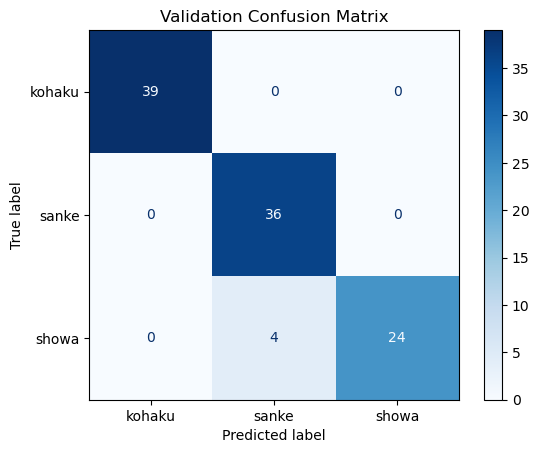

In [113]:
# check the classification report

print(classification_report(all_labels, all_preds, target_names=le.classes_))

# create the confusion matrix

cm = confusion_matrix(all_labels, all_preds)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap='Blues', values_format='d')
plt.title("Validation Confusion Matrix")
plt.show()

# Transfer Learning

In [118]:
# load pre-trained ResNet18

weights = ResNet18_Weights.DEFAULT
model = resnet18(weights=weights)

# freeze all layers

for param in model.parameters():
  param.requires_grad = False

# replace the final classifier layer
num_classes = len(le.classes_)
model.fc = nn.Linear(model.fc.in_features, num_classes)

In [119]:
# unfreeze the last few layers

for name, param in model.named_parameters():
  if "layer4" in name or "fc" in name:
    param.requires_grad = True
  else:
    param.requires_grad = False

In [120]:
# define the optimizer to only train unfrozen parameters

optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
criterion = nn.CrossEntropyLoss()
model = model.to(device)

# define a scheduler to reduce learning rate on plateau

scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

In [121]:
# create the training loop

num_epochs = 20

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# add early stopping

best_val_loss = float('inf')
patience = 5
epochs_no_improve = 0


for epoch in range(num_epochs):
  # set the model to training mode
  model.train()
  # initialize loss tracking
  total_train_loss = 0
  train_correct = 0
  train_total = 0

  # loop through training data in batches
  for images, labels in train_loader:
    images = images.to(device) # move data to MPS
    labels = labels.to(device) # move data to MPS

    # reset the gradients
    optimizer.zero_grad()
    # forward pass
    outputs = model(images)
    # compute the loss
    loss = criterion(outputs, labels)
    # backward pass
    loss.backward()
    # update model weights
    optimizer.step()

    # add batch loss to total
    total_train_loss += loss.item()

    _, predicted = torch.max(outputs, 1)
    train_correct += (predicted == labels).sum().item()
    train_total += labels.size(0)

  avg_train_loss = total_train_loss / len(train_loader)
  train_acc = train_correct / train_total

  train_losses.append(avg_train_loss)
  train_accuracies.append(train_acc)

  # VALIDATION
  model.eval()
  total_val_loss = 0
  val_correct = 0
  val_total = 0

  with torch.no_grad():
    for images, labels in val_loader:
      images = images.to(device)
      labels = labels.to(device)

      outputs = model(images)
      loss = criterion(outputs, labels)
      total_val_loss += loss.item()

      _, predicted = torch.max(outputs, 1)
      val_correct += (predicted == labels).sum().item()
      val_total += labels.size(0)

  avg_val_loss = total_val_loss / len(val_loader)
  val_acc = val_correct / val_total

  val_losses.append(avg_val_loss)
  val_accuracies.append(val_acc)

  # print loss for this epochs
  print(f"Epoch {epoch+1}/{num_epochs} | "
        f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.2%} | "
        f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.2%} | "
        f"Current LR:", optimizer.param_groups[0]['lr'])

  scheduler.step(avg_val_loss)

  if avg_val_loss < best_val_loss:
    best_val_loss = avg_val_loss
    epochs_no_improve = 0
    torch.save(model.state_dict(), 'best_model.pt')
  else:
    epochs_no_improve += 1

  if epochs_no_improve >= patience:
    print(f"Early stopping at epoch {epoch+1}")
    break

Epoch 1/20 | Train Loss: 0.5800, Train Acc: 77.08% | Val Loss: 0.8041, Val Acc: 77.67% | Current LR: 0.001
Epoch 2/20 | Train Loss: 0.1729, Train Acc: 93.96% | Val Loss: 0.5992, Val Acc: 88.35% | Current LR: 0.001
Epoch 3/20 | Train Loss: 0.0581, Train Acc: 97.92% | Val Loss: 0.1436, Val Acc: 91.26% | Current LR: 0.001
Epoch 4/20 | Train Loss: 0.0240, Train Acc: 99.38% | Val Loss: 0.1550, Val Acc: 95.15% | Current LR: 0.001
Epoch 5/20 | Train Loss: 0.0084, Train Acc: 100.00% | Val Loss: 0.1794, Val Acc: 94.17% | Current LR: 0.001
Epoch 6/20 | Train Loss: 0.0116, Train Acc: 99.79% | Val Loss: 0.1282, Val Acc: 95.15% | Current LR: 0.001
Epoch 7/20 | Train Loss: 0.0040, Train Acc: 100.00% | Val Loss: 0.1112, Val Acc: 95.15% | Current LR: 0.001
Epoch 8/20 | Train Loss: 0.0037, Train Acc: 100.00% | Val Loss: 0.0643, Val Acc: 97.09% | Current LR: 0.001
Epoch 9/20 | Train Loss: 0.0020, Train Acc: 100.00% | Val Loss: 0.0528, Val Acc: 97.09% | Current LR: 0.001
Epoch 10/20 | Train Loss: 0.0020,

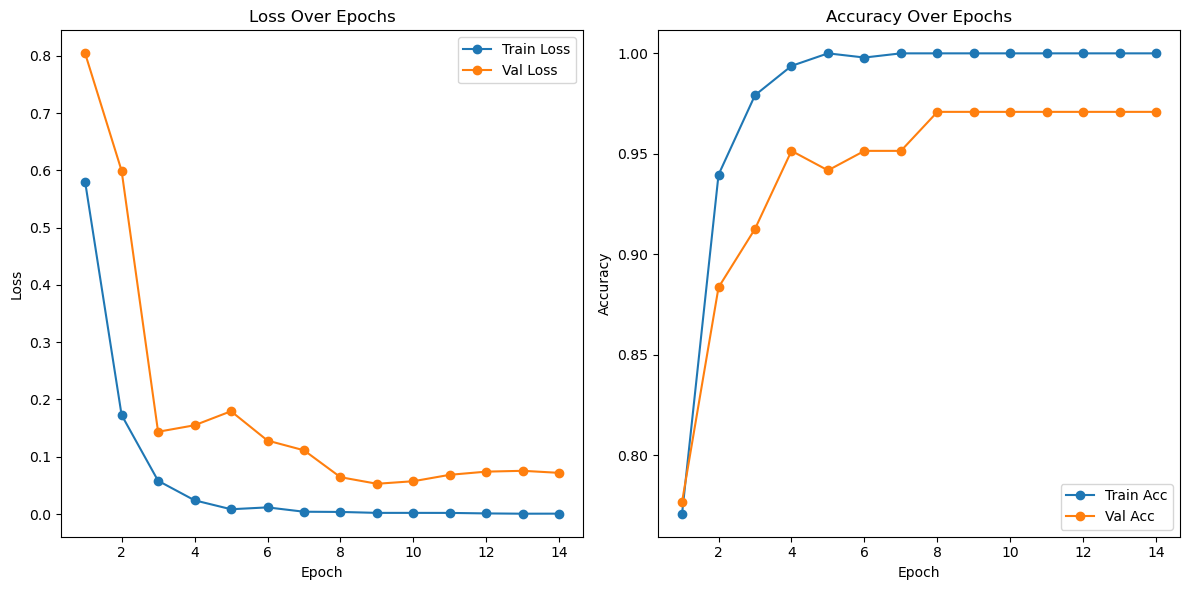

In [125]:
# plot the loss and accuracy over epochs

epochs = range(1, 15)
plt.figure(figsize=(12,6))

# plot the loss
plt.subplot(1,2,1)
plt.plot(epochs, train_losses, label='Train Loss', marker='o')
plt.plot(epochs, val_losses, label='Val Loss', marker ='o')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# plot the accuracy
plt.subplot(1,2,2)
plt.plot(epochs, train_accuracies, label='Train Acc', marker='o')
plt.plot(epochs, val_accuracies, label='Val Acc', marker='o')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

              precision    recall  f1-score   support

      kohaku       1.00      1.00      1.00        39
       sanke       0.90      1.00      0.95        36
       showa       1.00      0.86      0.92        28

    accuracy                           0.96       103
   macro avg       0.97      0.95      0.96       103
weighted avg       0.97      0.96      0.96       103



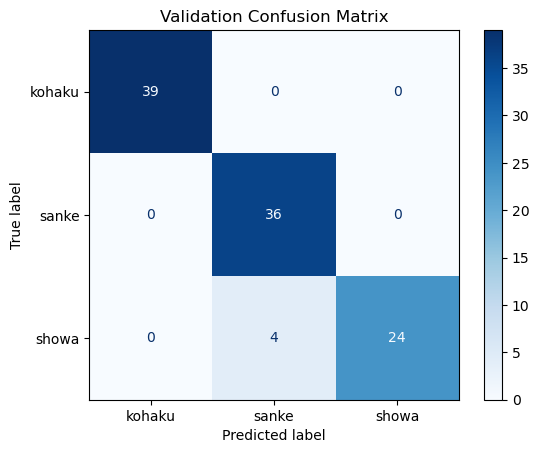

In [126]:
# check the classification report

print(classification_report(all_labels, all_preds, target_names=le.classes_))

# create the confusion matrix

cm = confusion_matrix(all_labels, all_preds)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap='Blues', values_format='d')
plt.title("Validation Confusion Matrix")
plt.show()

# Evaluate on Test Dataset

In [127]:
# check the performance of the model on TEST dataset

model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
  for images, labels in test_loader:
    images = images.to(device)
    labels = labels.to(device)

    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

    all_preds.extend(predicted.cpu().numpy())
    all_labels.extend(labels.cpu().numpy())

test_acc = accuracy_score(all_labels, all_preds)
print(f"Test Accuracy: {test_acc:.2%}")

Test Accuracy: 93.20%


              precision    recall  f1-score   support

      kohaku       0.95      1.00      0.98        40
       sanke       0.94      0.91      0.93        35
       showa       0.89      0.86      0.87        28

    accuracy                           0.93       103
   macro avg       0.93      0.92      0.93       103
weighted avg       0.93      0.93      0.93       103



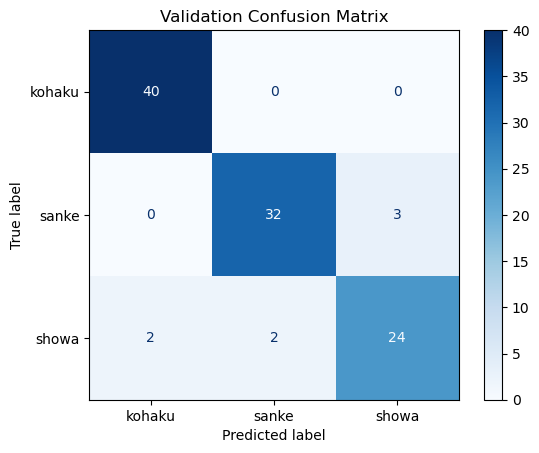

In [128]:
# check the classification report

print(classification_report(all_labels, all_preds, target_names=le.classes_))

# create the confusion matrix

cm = confusion_matrix(all_labels, all_preds)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap='Blues', values_format='d')
plt.title("Validation Confusion Matrix")
plt.show()